In [1]:
import pandas as pd
import numpy as np 
import math
import sys

from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

import importlib
import smlmodule

from itertools import combinations
from pprint import pprint

"""
https://bmjopen.bmj.com/content/10/9/e039338

We have computed the number of COVID-19 infected people for each province and the infection 
rate based on the number of inhabitants from February 24th to March 13th (the date when the 
lockdown was decided), as reported by the official government website, updated with daily 
frequency.34 The number of PM exceedances were computed between February 9th and February 29th, 
as we had to take into account the maximum lag period of 14 days, which is the average time 
elapsed between the contagion and the first weeks of the Italian epidemic 
(February 24th to March 13th). 

period1 = ['2020-02-09', '2020-02-28'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-24', '2020-03-13']

period2 = ['2020-02-09', '2020-03-06] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-09', '2020-03-21']
period3 = ['2020-08-29', '2020-09-01'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-10-15']
period4 = ['2020-08-29', '2020-10-30'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-11-14']
period5 = ['2020-05-15', '2020-08-15'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-06-01', '2020-09-01']
"""


LIMIT = 0.95

verbose = False
paperpath = "./data/particulate.csv"
agefeatspath = "./data/provinceages.csv"
deprividxpath = "./data/ID11_prov21.xlsx"
tabellecodicipath = "./data/TabelleCodici.xlsx"
copernicopath = "./data/name_region_province_statistics_2020.csv"

__provmaps__ = {
    "bolzano_bozen": "bolzano",
    "bolzanobozen": "bolzano",
    "vibovalentia": "vibo_valentia",
    "laquila": "l_aquila",
    "laspezia": "la_spezia",
    "barlettaandriatrani": "bat",
    "ascolipiceno": "ascoli_piceno",
    "carboniaiglesias": "carbonia",
    "reggioemilia": "reggio_nell_emilia",
    "pesarourbino": "pesaro",
    "monzabrianza": "monza",
    "reggiocalabria": "reggio_di_calabria",
    "forlicesena": "forli",
    "massacarrara": "massa",
    "verbanocusioossola": "verbania",
    "verbano_cusio_ossola": "verbania",
    "massa_carrara": "massa",
    "monza_e_della_brianza": "monza",
    "pesaro_e_urbino": "pesaro",
    "forli__cesena": "forli",
    "bolzano_/_bozen": "bolzano",
    "barletta_andria_trani": "bat",
    "sud_sardegna": "carbonia",
    "forlì_cesena": "forli"
}

pollutantsnames = "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020," +\
        "sum_wnh3_ex_q75_period1_2020," +\
        "sum_wnmvoc_ex_q75_period1_2020," +\
        "sum_wno2_ex_q75_period1_2020," +\
        "sum_wno_ex_q75_period1_2020," +\
        "sum_wpans_ex_q75_period1_2020," +\
        "sum_wpm10_ex_q75_period1_2020," +\
        "sum_wpm2p5_ex_q75_period1_2020," +\
        "sum_wo3_ex_q75_period1_2020," + \
        "sum_wco_ex_q75_period1_2020," + \
        "sum_wso2_ex_q75_period1_2020"

featurestobeused = "density," + \
        "commutersdensity," + \
        "depriv," + \
        "lat," + \
        "Ratio0200ver65," + \
        "exoverstation," + \
        "sum_wco_ex_q75_period1_2020,"+\
        "sum_wnh3_ex_q75_period1_2020,"+\
        "sum_wnmvoc_ex_q75_period1_2020,"+\
        "sum_wno2_ex_q75_period1_2020,"+\
        "sum_wno_ex_q75_period1_2020,"+\
        "sum_wo3_ex_q75_period1_2020,"+\
        "sum_wpans_ex_q75_period1_2020,"+\
        "sum_wpm10_ex_q75_period1_2020,"+\
        "sum_wpm2p5_ex_q75_period1_2020,"+\
        "sum_wso2_ex_q75_period1_2020"

def filterprovname (inprov):
    low = inprov.lower()
    low = low.rstrip()
    low = low.lstrip()
    low = low.replace(" ", "_")
    low = low.replace("'", "_")
    low = low.replace("-", "_")

    return low

def normalize_provname (indata, provcolumn, verbose):

    dict_data = {}  
    for c in indata.columns:
        if verbose:
            print("  ", c)
        if c != provcolumn:
            dict_data[c] = []
    dict_data["prov"] = []

    for i, row in indata.iterrows():
        for c in indata.columns:    
            if c != provcolumn:
                dict_data[c].append(row[c])
            else:
                low = filterprovname(row[c])
                if low in __provmaps__:
                    low = __provmaps__[low]

                dict_data["prov"].append(low)

    #for v in dict_data:
    #    print(v, " ", len(dict_data[v]))

    data = pd.DataFrame.from_dict(dict_data)

    return data

In [2]:
tc = pd.ExcelFile(tabellecodicipath)

idtoprov = {}
province = tc.parse("Codice Provincia")
for val in province[["Codice Provincia","Nome Provincia"]].values:
    if type(val[1]) != float:
        idtoprov[int(val[0])] = val[1]
        #print(int(val[0]), val[1])

in_datapaper = pd.read_csv(paperpath, sep=";")
in_deprividx =  pd.ExcelFile(deprividxpath).parse("Foglio1")
in_agefeatures = pd.read_csv(agefeatspath)
in_agefeatures = in_agefeatures[in_agefeatures.Population2020 != 0.0]
in_copernico = pd.read_csv(copernicopath)

print("Paper data ")
datapaper = normalize_provname(in_datapaper, "Province", False)
print("Age features ")
agefeatures = normalize_provname(in_agefeatures, "Provincia", False)
print("Copernico data ") 
copernico = normalize_provname(in_copernico, "nome_ita", False)

dict_deprividx = {}
print("DrepivIdx name ")
for c in in_deprividx.columns:
    if verbose:
        print("   ", c)   
    dict_deprividx[c] = []
dict_deprividx["prov"] = []

for i, row in in_deprividx.iterrows():
    id = row["prov21"]
    prov = filterprovname(idtoprov[id])
    
    if prov in __provmaps__:
        prov = __provmaps__[prov]
    
    #print(id, prov)
    dict_deprividx["prov"].append(prov)
    for c in in_deprividx.columns:
        dict_deprividx[c].append(row[c])


deprividx = pd.DataFrame.from_dict(dict_deprividx)       

provincelist = list(set(list(datapaper["prov"].values)) & \
        set(list(deprividx["prov"].values)) & \
        set(list(agefeatures["prov"].values)) &
        set(list(copernico["prov"].values)))

print("Province list: ")
for i, p in enumerate(provincelist):
    print("  ", i+1, " ", p)

Paper data 
Age features 
Copernico data 
DrepivIdx name 
Province list: 
   1   crotone
   2   terni
   3   catania
   4   siracusa
   5   genova
   6   potenza
   7   pisa
   8   ragusa
   9   agrigento
   10   bologna
   11   massa
   12   viterbo
   13   rieti
   14   fermo
   15   sassari
   16   oristano
   17   avellino
   18   lodi
   19   trieste
   20   pescara
   21   carbonia
   22   messina
   23   lecce
   24   como
   25   la_spezia
   26   gorizia
   27   palermo
   28   bolzano
   29   latina
   30   perugia
   31   varese
   32   alessandria
   33   firenze
   34   foggia
   35   belluno
   36   bergamo
   37   trapani
   38   arezzo
   39   ferrara
   40   sondrio
   41   ancona
   42   grosseto
   43   bari
   44   vicenza
   45   campobasso
   46   vercelli
   47   treviso
   48   livorno
   49   rimini
   50   pesaro
   51   roma
   52   caserta
   53   pistoia
   54   napoli
   55   venezia
   56   asti
   57   lucca
   58   cosenza
   59   cagliari
   60   biell

In [3]:
counter = 0

for prov in provincelist:
    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]
    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 

    #if diff < 5.0 :
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        counter += 1
        print(counter, prov)

ylogpropcasi = []
features_dict = {}

for fn in ("population", "density", "commutersdensity", "depriv", \
    "lat", "Ratio0200ver65","exoverstation"):
    features_dict[fn] = np.zeros(counter, dtype="float64")

for fn in pollutantsnames.split(","):
    features_dict[fn] = np.zeros(counter, dtype="float64")

i = 0 
for idx, prov in enumerate(provincelist):

    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]

    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 
    
    ycasi = cases/popolazione

    #if diff < 5.0:
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        if ycasi == 0.0:
           ylogpropcasi.append(-13.0) 
        else:
            ylogpropcasi.append(math.log(ycasi)) # atural logarithm of different numbers

        selected = copernico[copernico["prov"] == prov]

        features_dict["population"][i] = popolazione
        features_dict["density"][i] = \
                    datapaper[datapaper["prov"] == prov]["Density"].values[0]    
        features_dict["commutersdensity"][i] = \
                    datapaper[datapaper["prov"] == prov]["CommutersDensity"].values[0]       
        features_dict["lat"][i] = \
                    datapaper[datapaper["prov"] == prov]["Lat"].values[0]       
        features_dict["depriv"][i] = \
                    deprividx[deprividx["prov"] == prov]["ID_2011"].values[0]
        #print(idx, prov, agefeatures[agefeatures["prov"] == prov])
        features_dict["Ratio0200ver65"][i] = \
                    agefeatures[agefeatures["prov"] == prov]["Ratio0200ver65"].values[0]

        for fn in pollutantsnames.split(","):
            val = selected[fn].values[0]
            features_dict[fn][i] = val 

        #features_dict["exoverstation"][i] = Exceedances/StationsNum


        i = i + 1

1 crotone
2 terni
3 catania
4 siracusa
5 genova
6 potenza
7 pisa
8 ragusa
9 agrigento
10 bologna
11 massa
12 viterbo
13 rieti
14 fermo
15 sassari
16 oristano
17 avellino
18 lodi
19 trieste
20 pescara
21 messina
22 lecce
23 como
24 la_spezia
25 gorizia
26 palermo
27 bolzano
28 latina
29 perugia
30 varese
31 alessandria
32 firenze
33 foggia
34 belluno
35 bergamo
36 trapani
37 arezzo
38 ferrara
39 sondrio
40 ancona
41 grosseto
42 bari
43 vicenza
44 campobasso
45 vercelli
46 treviso
47 livorno
48 rimini
49 pesaro
50 roma
51 caserta
52 pistoia
53 napoli
54 venezia
55 asti
56 lucca
57 cosenza
58 cagliari
59 biella
60 chieti
61 torino
62 pavia
63 pordenone
64 matera
65 padova
66 verona
67 ravenna
68 reggio_di_calabria
69 bat
70 cuneo
71 teramo
72 brindisi
73 mantova
74 ascoli_piceno
75 salerno
76 prato
77 vibo_valentia
78 verbania
79 reggio_nell_emilia
80 modena
81 catanzaro
82 piacenza
83 benevento
84 savona
85 frosinone
86 nuoro
87 macerata
88 trento
89 lecco
90 cremona
91 milano
92 imperia

In [4]:
# nomalize values
new_features_dict = {}
for fn in features_dict:
    #print(fn)
    abs_max = np.amax(np.abs(features_dict[fn]))
    if abs_max == 0.0:
        print (fn, " will be removed ")
        print (features_dict[fn])
    else:
        new_features_dict[fn] = features_dict[fn] * (1.0 / abs_max)

features_dict = new_features_dict

highcorrelated = {}
for i1, v1 in enumerate(features_dict):
    highcorrelated[v1] = []
    for i2, v2 in enumerate(features_dict):
        #if v1 != v2 and i2 > i1:
        if v1 != v2:
            corr, _ = pearsonr(features_dict[v1], features_dict[v2])
            if math.fabs(corr) > LIMIT:
                highcorrelated[v1].append(v2)
                #print(v1, v2, corr)

    #if len(highcorrelated[v1]) > 0:
    #    print(v1)
    #    for fntr in highcorrelated[v1]:
    #        print("   ", fntr)

removedfeatures = []
features = []
for fn in featurestobeused.split(","):
    if fn in features_dict:
        canadd = True
        for fnin in features:
            if fn in highcorrelated[fnin]:
                canadd = False
                break

        if canadd:
            print("Using: %30s"%fn)
            features.append(fn)
        else:
            removedfeatures.append(fn)


print("")
for fn in removedfeatures:
    print("Highly correlated removing %30s"%fn)
    for cf  in highcorrelated[fn]:
        print("     ",cf)
print(" ")

exoverstation  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wo3_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wco_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.

Training set average RMSE:  0.35378  0.02414 
    Test set average RMSE:  0.95431  0.07096 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.35533
                       R2:  0.94222


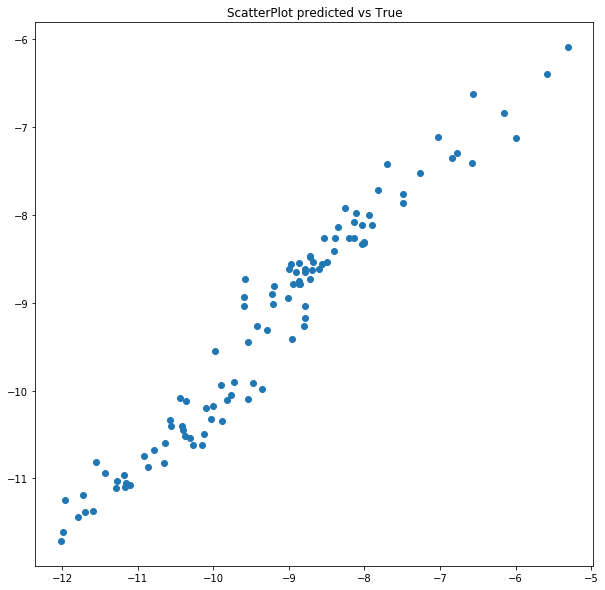

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.04843
Feature:               commutersdensity, Score: 0.02524
Feature:                         depriv, Score: 0.04797
Feature:                            lat, Score: 0.69580
Feature:                 Ratio0200ver65, Score: 0.08729
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.00938
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.00945
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.01144
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.02671
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.02419
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.00748
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.00662


<Figure size 432x288 with 0 Axes>

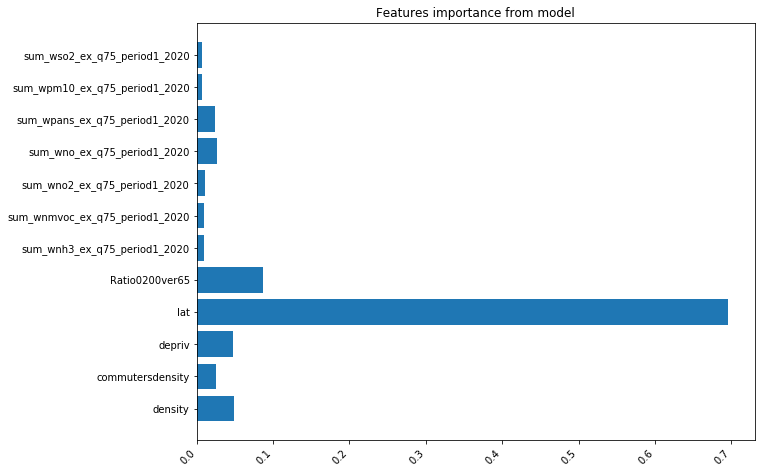

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.10422 +/- 0.01061
Feature:               commutersdensity, Score: 0.07407 +/- 0.00970
Feature:                         depriv, Score: 0.15173 +/- 0.01518
Feature:                            lat, Score: 3.24137 +/- 0.41598
Feature:                 Ratio0200ver65, Score: 0.24402 +/- 0.03950
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.02756 +/- 0.00680
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.01172 +/- 0.00241
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.01933 +/- 0.00290
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.07361 +/- 0.01577
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.05125 +/- 0.01248
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.01814 +/- 0.00298
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.01528 +/- 0.00310


<Figure size 432x288 with 0 Axes>

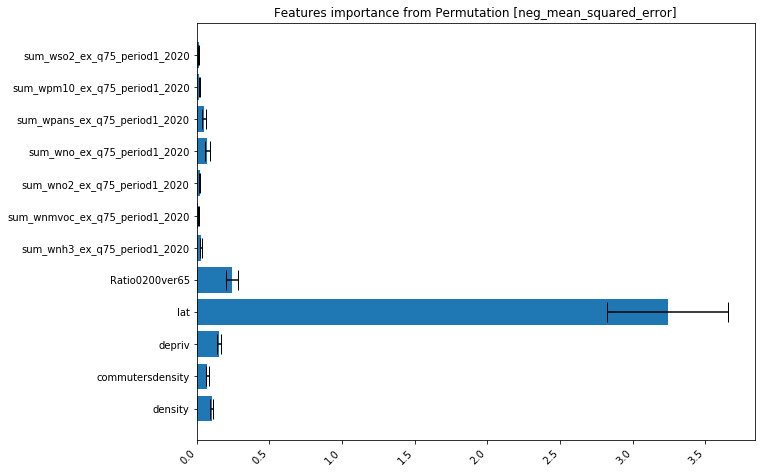

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.04769 +/- 0.00485
Feature:               commutersdensity, Score: 0.03389 +/- 0.00444
Feature:                         depriv, Score: 0.06944 +/- 0.00695
Feature:                            lat, Score: 1.48329 +/- 0.19036
Feature:                 Ratio0200ver65, Score: 0.11167 +/- 0.01808
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.01261 +/- 0.00311
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.00536 +/- 0.00111
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.00884 +/- 0.00133
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.03369 +/- 0.00722
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.02345 +/- 0.00571
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.00830 +/- 0.00136
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.00699 +/- 0.00142


<Figure size 432x288 with 0 Axes>

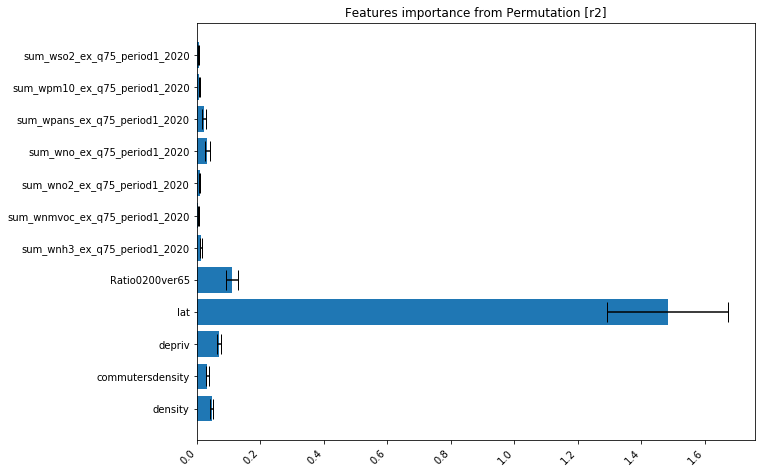

<Figure size 720x720 with 0 Axes>

((0.3537760617328245, 0.024142547872792058),
 (0.9543134155989708, 0.07095978676065648),
 0.35533174116058747,
 {'density': 0.025845797596758188,
  'commutersdensity': 0.01836870752132038,
  'depriv': 0.03762960593531851,
  'lat': 0.803849908623148,
  'Ratio0200ver65': 0.06051703129226386,
  'sum_wnh3_ex_q75_period1_2020': 0.006835702158819269,
  'sum_wnmvoc_ex_q75_period1_2020': 0.0029062582414658283,
  'sum_wno2_ex_q75_period1_2020': 0.004792637306377428,
  'sum_wno_ex_q75_period1_2020': 0.018255961044593108,
  'sum_wpans_ex_q75_period1_2020': 0.01271079973560199,
  'sum_wpm10_ex_q75_period1_2020': 0.004497670612439716,
  'sum_wso2_ex_q75_period1_2020': 0.0037899199318938005},
 {'density': 0.025845797596758167,
  'commutersdensity': 0.01836870752132037,
  'depriv': 0.0376296059353185,
  'lat': 0.8038499086231482,
  'Ratio0200ver65': 0.06051703129226387,
  'sum_wnh3_ex_q75_period1_2020': 0.006835702158819253,
  'sum_wnmvoc_ex_q75_period1_2020': 0.002906258241465807,
  'sum_wno2_ex_q75

<Figure size 432x288 with 0 Axes>

In [5]:
#finalfeaturestobeused = "density,commutersdensity,exoverstation"
#features = finalfeaturestobeused.split(",")
#listostack = [features_dict[v] for v in features]

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, plotname="rf_model_allfeatures_using_sum", pout=sys.stdout, showplot=True)

In [6]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

1  of  1200 MSE:  0.12626064627621472
2  of  1200 MSE:  0.12043639276790571
3  of  1200 MSE:  0.20436198103830477
4  of  1200 MSE:  0.27874016531598983
5  of  1200 MSE:  0.4407211549683421
6  of  1200 MSE:  0.5616854698774321
7  of  1200 MSE:  0.610026119293541
8  of  1200 MSE:  0.7073701879511591
9  of  1200 MSE:  0.19213198248562185
10  of  1200 MSE:  0.23452622950671012
11  of  1200 MSE:  0.23064836068817823
12  of  1200 MSE:  0.3119560004800811
13  of  1200 MSE:  0.4407211549683421
14  of  1200 MSE:  0.5616854698774321
15  of  1200 MSE:  0.610026119293541
16  of  1200 MSE:  0.7073701879511591
17  of  1200 MSE:  0.3379529764095299
18  of  1200 MSE:  0.4411347376241998
19  of  1200 MSE:  0.36322572693588345
20  of  1200 MSE:  0.46832613325792766
21  of  1200 MSE:  0.4407211549683421
22  of  1200 MSE:  0.5616854698774321
23  of  1200 MSE:  0.610026119293541
24  of  1200 MSE:  0.7073701879511591
25  of  1200 MSE:  0.4536950998639489
26  of  1200 MSE:  0.5538469621623778
27  of  1200 MS

{'bootstrap': True,
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1200,
 'random_state': 1}
Training set average RMSE:  0.34809  0.02457 
    Test set average RMSE:  0.95109  0.10785 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.33436
                       R2:  0.94884


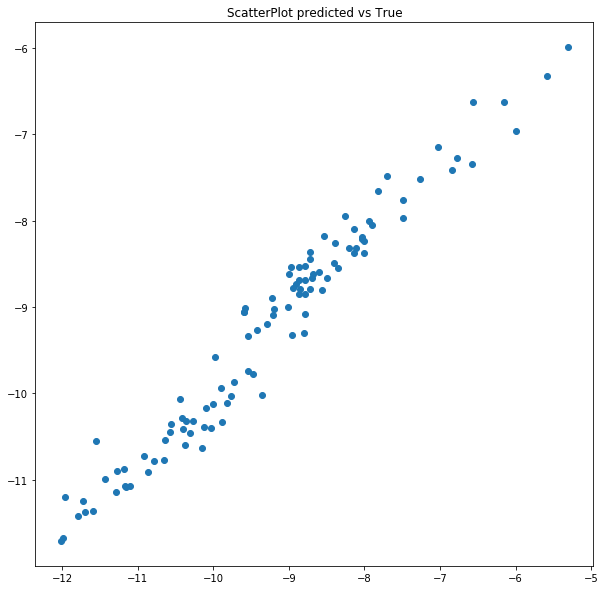

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.05907
Feature:               commutersdensity, Score: 0.16938
Feature:                         depriv, Score: 0.10190
Feature:                            lat, Score: 0.26117
Feature:                 Ratio0200ver65, Score: 0.08058
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.07026
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.05901
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.09159
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.01921
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.02296
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.04349
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.02139


<Figure size 432x288 with 0 Axes>

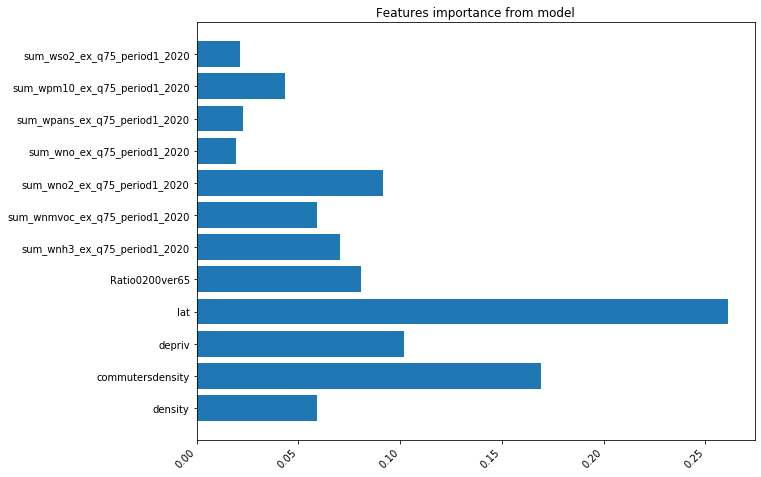

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.10354 +/- 0.01023
Feature:               commutersdensity, Score: 0.06327 +/- 0.00734
Feature:                         depriv, Score: 0.15675 +/- 0.01520
Feature:                            lat, Score: 3.03366 +/- 0.39260
Feature:                 Ratio0200ver65, Score: 0.19180 +/- 0.03167
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.01944 +/- 0.00505
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.01885 +/- 0.00388
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.02030 +/- 0.00337
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.08046 +/- 0.01872
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.04738 +/- 0.01186
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.02523 +/- 0.00405
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.01386 +/- 0.00246


<Figure size 432x288 with 0 Axes>

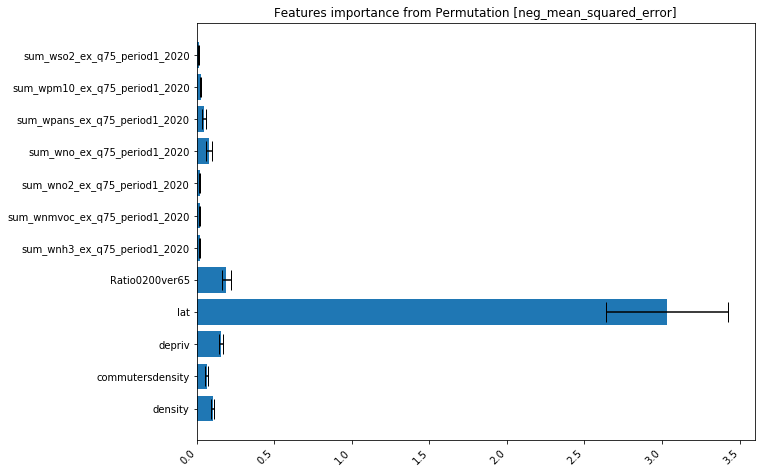

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.04738 +/- 0.00468
Feature:               commutersdensity, Score: 0.02895 +/- 0.00336
Feature:                         depriv, Score: 0.07173 +/- 0.00696
Feature:                            lat, Score: 1.38824 +/- 0.17966
Feature:                 Ratio0200ver65, Score: 0.08777 +/- 0.01449
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.00889 +/- 0.00231
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.00863 +/- 0.00177
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.00929 +/- 0.00154
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.03682 +/- 0.00857
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.02168 +/- 0.00543
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.01154 +/- 0.00185
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.00634 +/- 0.00112


<Figure size 432x288 with 0 Axes>

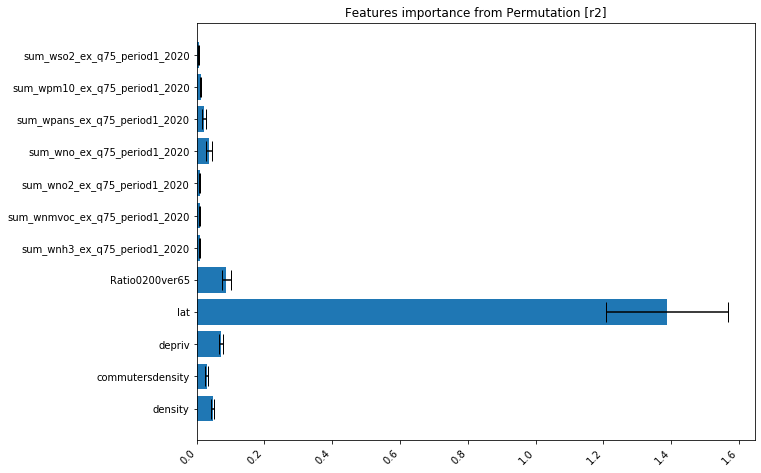

<Figure size 720x720 with 0 Axes>

((0.3480878024349313, 0.02456671798636314),
 (0.9510931627267576, 0.10784508621577046),
 0.33436048818251557,
 {'density': 0.02743181088931289,
  'commutersdensity': 0.016761578380633652,
  'depriv': 0.041529632290127,
  'lat': 0.8037183093320358,
  'Ratio0200ver65': 0.05081385606535274,
  'sum_wnh3_ex_q75_period1_2020': 0.00514918974045271,
  'sum_wnmvoc_ex_q75_period1_2020': 0.004993851963597055,
  'sum_wno2_ex_q75_period1_2020': 0.005377745428612878,
  'sum_wno_ex_q75_period1_2020': 0.02131623138565401,
  'sum_wpans_ex_q75_period1_2020': 0.012552529560740482,
  'sum_wpm10_ex_q75_period1_2020': 0.006683263743482065,
  'sum_wso2_ex_q75_period1_2020': 0.003672001219998674},
 {'density': 0.02743181088931291,
  'commutersdensity': 0.016761578380633673,
  'depriv': 0.041529632290127,
  'lat': 0.8037183093320355,
  'Ratio0200ver65': 0.05081385606535275,
  'sum_wnh3_ex_q75_period1_2020': 0.005149189740452727,
  'sum_wnmvoc_ex_q75_period1_2020': 0.004993851963597077,
  'sum_wno2_ex_q75_perio

<Figure size 432x288 with 0 Axes>

In [7]:
pprint(bestf)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_allfeatures_opt_using_sum",showplot=True, optimisedparams=bestf)

Training set average RMSE:  0.38952  0.03478 
    Test set average RMSE:  1.04680  0.12438 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.36481
                       R2:  0.93910


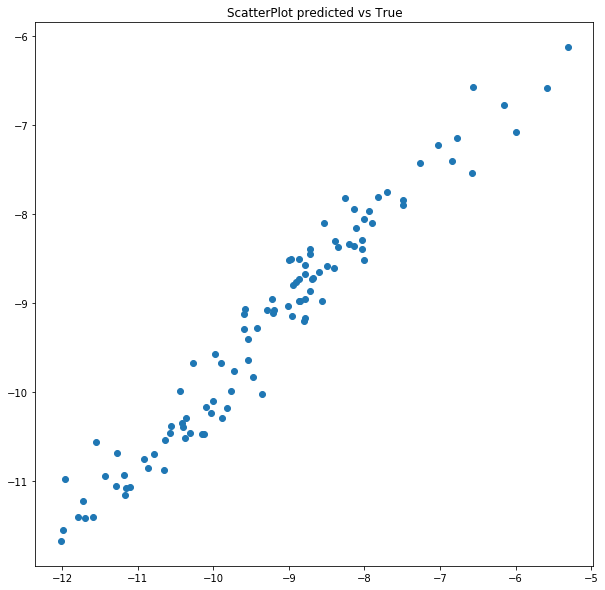

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.06860
Feature:               commutersdensity, Score: 0.50350
Feature:                         depriv, Score: 0.09118
Feature:                 Ratio0200ver65, Score: 0.14087
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.03865
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.03077
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.03844
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.02884
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.02321
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.01732
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.01864


<Figure size 432x288 with 0 Axes>

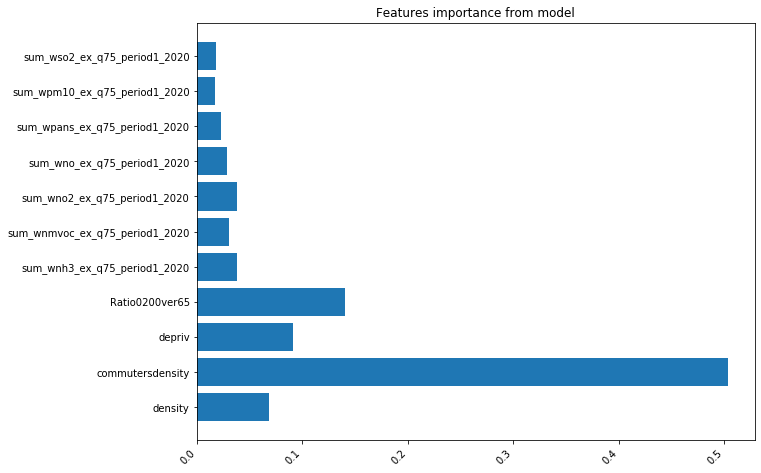

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.14779 +/- 0.01829
Feature:               commutersdensity, Score: 1.87539 +/- 0.32196
Feature:                         depriv, Score: 0.24847 +/- 0.02779
Feature:                 Ratio0200ver65, Score: 0.35133 +/- 0.04277
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.05552 +/- 0.01154
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.04070 +/- 0.00787
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.08085 +/- 0.01149
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.06225 +/- 0.01523
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.07958 +/- 0.01483
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.03422 +/- 0.00529
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.03254 +/- 0.00695


<Figure size 432x288 with 0 Axes>

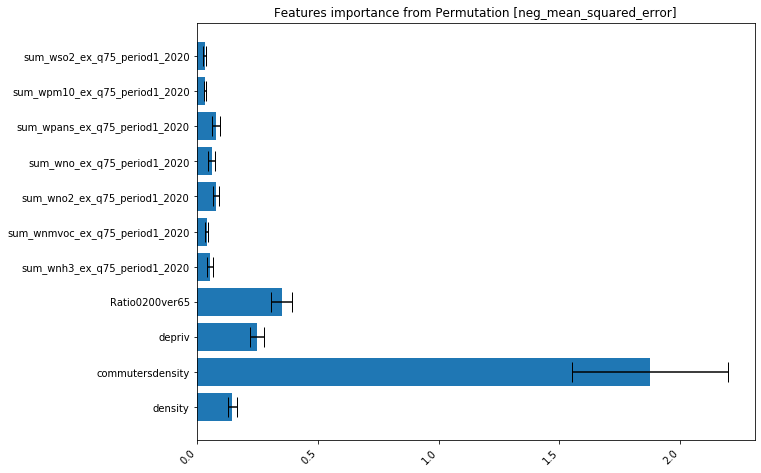

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.06763 +/- 0.00837
Feature:               commutersdensity, Score: 0.85820 +/- 0.14734
Feature:                         depriv, Score: 0.11370 +/- 0.01272
Feature:                 Ratio0200ver65, Score: 0.16077 +/- 0.01957
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.02541 +/- 0.00528
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.01863 +/- 0.00360
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.03700 +/- 0.00526
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.02849 +/- 0.00697
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.03642 +/- 0.00679
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.01566 +/- 0.00242
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.01489 +/- 0.00318


<Figure size 432x288 with 0 Axes>

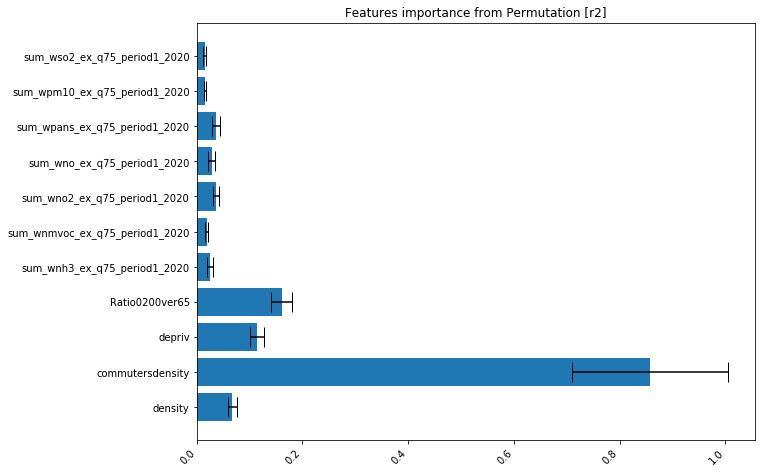

<Figure size 720x720 with 0 Axes>

((0.38952434592568225, 0.03477823169261712),
 (1.0467986196864958, 0.12438375438076914),
 0.36480533973869117,
 {'density': 0.04912204944973033,
  'commutersdensity': 0.6233336729215306,
  'depriv': 0.08258566455924878,
  'Ratio0200ver65': 0.11677220506198033,
  'sum_wnh3_ex_q75_period1_2020': 0.018454423062832244,
  'sum_wnmvoc_ex_q75_period1_2020': 0.013528792629677591,
  'sum_wno2_ex_q75_period1_2020': 0.026871479854012236,
  'sum_wno_ex_q75_period1_2020': 0.02069062642600237,
  'sum_wpans_ex_q75_period1_2020': 0.026451102084231033,
  'sum_wpm10_ex_q75_period1_2020': 0.011374709904937984,
  'sum_wso2_ex_q75_period1_2020': 0.010815274045816286},
 {'density': 0.04912204944973037,
  'commutersdensity': 0.6233336729215306,
  'depriv': 0.08258566455924882,
  'Ratio0200ver65': 0.11677220506198038,
  'sum_wnh3_ex_q75_period1_2020': 0.01845442306283228,
  'sum_wnmvoc_ex_q75_period1_2020': 0.013528792629677624,
  'sum_wno2_ex_q75_period1_2020': 0.026871479854012274,
  'sum_wno_ex_q75_period1

<Figure size 432x288 with 0 Axes>

In [8]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, plotname="rf_model_nolat_using_sum", pout=sys.stdout, showplot=True)

In [9]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

1  of  1200 MSE:  0.1330829359018619
2  of  1200 MSE:  0.12844689663400238
3  of  1200 MSE:  0.23669656822135834
4  of  1200 MSE:  0.32799739504516745
5  of  1200 MSE:  0.5381427059311817
6  of  1200 MSE:  0.6500438111202963
7  of  1200 MSE:  0.7683960662464437
8  of  1200 MSE:  0.8174595014584336
9  of  1200 MSE:  0.21510927851619013
10  of  1200 MSE:  0.2969465702787487
11  of  1200 MSE:  0.27200978897123523
12  of  1200 MSE:  0.3723965852865956
13  of  1200 MSE:  0.5381427059311817
14  of  1200 MSE:  0.6500438111202963
15  of  1200 MSE:  0.7683960662464437
16  of  1200 MSE:  0.8174595014584336
17  of  1200 MSE:  0.3858649228036776
18  of  1200 MSE:  0.48774901401862153
19  of  1200 MSE:  0.43127989395854416
20  of  1200 MSE:  0.5266444751010871
21  of  1200 MSE:  0.5381427059311817
22  of  1200 MSE:  0.6500438111202963
23  of  1200 MSE:  0.7683960662464437
24  of  1200 MSE:  0.8174595014584336
25  of  1200 MSE:  0.5013324649418796
26  of  1200 MSE:  0.6103033550921133
27  of  1200 M

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_nolat_opt_using_sum", showplot=True, optimisedparams=bestf)

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, plotname="rf_model_nolat_nocom_using_sum", pout=sys.stdout, showplot=True)

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_nolat_nocom_opt_using_sum", showplot=True, optimisedparams=bestf)